In [37]:
from pydrake.all import (
    Variable,
    SymbolicVectorSystem,
    DiagramBuilder,
    LogVectorOutput,
    Simulator,
    ConstantVectorSource,
    MathematicalProgram,
    Solve,
    SnoptSolver,
    PiecewisePolynomial,
)
import numpy as np
import matplotlib.pyplot as plt

In [47]:
# numeric parameters
n = 2 # trajectory order
m = 2 # number of keyframes
keyframes = np.array([0.0, 5.0, 10.0])
ts = 1.0

# initialize optimization
prog = MathematicalProgram()

# optimization variables
sigma = prog.NewContinuousVariables(n*m, "sigma")

# Initial state constraints
prog.AddConstraint(sigma[0] == 0.0)

# Dynamics/Keyframe constraints
for i in range(m):
    prog.AddConstraint(float(keyframes[i+1]) == float(keyframes[i]) + ts*sigma[i*n] + .5*ts**2*sigma[i*n+1])

for i in range(m-1):
    prog.AddConstraint(sigma[(i+1)*n] == sigma[i*n] + ts*sigma[i*n+1])
    # prog.AddConstraint(sigma[])

# Constraint to keep numerics nice before we scale time
# for i in range(keyframes_x.shape[0]):
#     prog.AddConstraint(sigma[i*n + 1, 0] >= 1.0)

H = np.diag([0., 1., 0., 1.])
prog.AddCost(sigma.reshape(-1).T @ H @ sigma.reshape(-1))



In [48]:
# solve mathematical program
solver = SnoptSolver()
result = solver.Solve(prog)

# be sure that the solution is optimal
assert result.is_success()

# retrieve optimal solution
sigma_opt = result.GetSolution(sigma)
print(sigma_opt)

[  0.  10.  10. -10.]


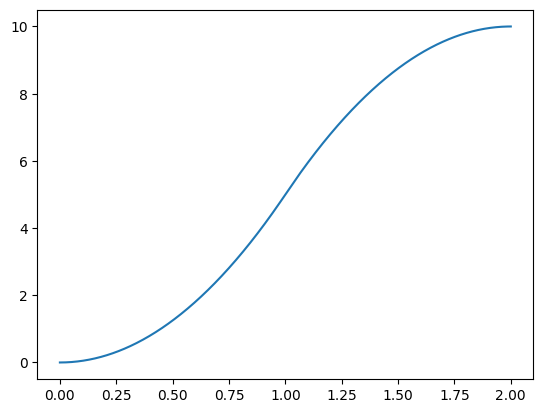

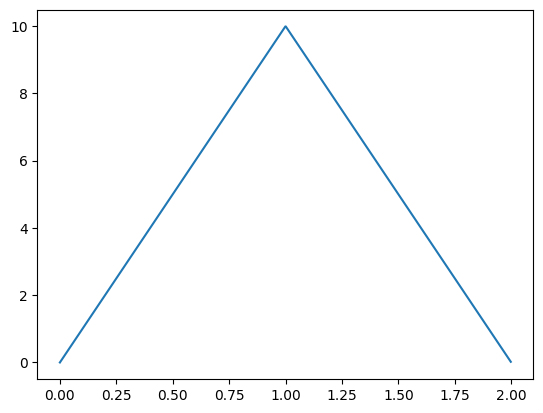

In [50]:
t = np.linspace(0, ts*m, 1000)

def x(sigma, t):
    interval = int(t / ts)
    curr_ts = t % ts
    if np.allclose(curr_ts, 0.0):
        return keyframes[interval]
    return keyframes[interval] + curr_ts*sigma[n*interval] + .5*curr_ts**2*sigma[n*interval+1]

def xdot(sigma, t):
    interval = int(t / ts)
    curr_ts = t % ts
    return sigma[n*interval] + curr_ts*sigma[n*interval+1]

x_vals = [x(sigma_opt, t[idx]) for idx in range(t.shape[0])]
plt.plot(t, x_vals)
plt.show()
xdot_vals = [xdot(sigma_opt, t[idx]) for idx in range(t.shape[0] - 1)]
plt.plot(t[:-1], xdot_vals)